# Case Study: Credit Card Approvals

## The Scene
You are a Data Scientist at a bank. You have a historical dataset of credit card applications. Some were **Approved (+)**, others were **Rejected (-)**.

Your boss asks: *"Can we visualize our customer base? Are the approved customers distinct from the rejected ones, or is it all mixed up?"*

Since the data is high-dimensional (Age, Debt, BankCustomer, Employment, etc.), you can't just plot `x` vs `y`. You need a way to map this high-dimensional data onto a 2D map.

**Enter the Self-Organizing Map (SOM).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

## 1. The Data Pipeline
Real-world data is messy. We are using the **UCI Credit Approval Dataset**.
- **Confidential**: All attribute names and values have been changed to meaningless symbols to protect user privacy.
- **Noisy**: It contains missing values (`?`) and a mix of numbers and text.

In [2]:
# Download and Load Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
dataset = pd.read_csv(url, header=None)

# Peek at the mess
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


### Data Cleaning
1.  **Missing Values**: The dataset uses `?` for missing info. We replace them with `NaN` and then impute (fill) them.
    - **Numerical Columns**: Fill with the **Mean**.
    - **Categorical Columns**: Fill with the **Mode** (Most frequent value).
2.  **Encoding**: Computers need numbers. We use `LabelEncoder` to turn text categories (e.g., 'u', 'y', 'l') into numbers (0, 1, 2...).

In [3]:
# 1. Handle '?'
dataset = dataset.replace('?', np.nan)

# 2. Impute Missing Values
for col in dataset.columns:
    # If categorical (Object/Text)
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    # If numerical
    else:
        dataset[col] = dataset[col].fillna(dataset[col].mean().iloc[0] if isinstance(dataset[col].mean(), pd.Series) else dataset[col].astype(float).mean())
        # Note: dataset needs explicit type conversion for mean if it was object before

# Fix type issues for mean calculation: Convert object-numerics to floats
# Actually replacing '?' might leave column as object. 
# Let's simply coerce numeric columns first.
for col in dataset.columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='ignore')
    
# Re-run fillna now that types are better
for col in dataset.columns:
    if dataset[col].dtype == 'object':
         dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    else:
         dataset[col] = dataset[col].fillna(dataset[col].mean())

# 3. Check for any remaining nulls
print("Remaining nulls:", dataset.isnull().sum().sum())

Remaining nulls: 0


/var/folders/fv/1glf1w45215d_trl8514hbnr0000gp/T/ipykernel_50527/2623438447.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset[col] = pd.to_numeric(dataset[col], errors='ignore')


In [4]:
# 4. Encode Categorical Data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = le.fit_transform(dataset[col])

dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,202,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120,0,0


### Feature Extraction & Scaling
- **X**: All columns except the last one (Attributes).
- **y**: The last column (Approved/Rejected).
- **Scaling**: SOMs use distance (Euclidean). We strictly scale everything to 0-1.

In [5]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)
print(f"Data Scaled. X shape: {X.shape}")

Data Scaled. X shape: (690, 15)


## 2. The Model (SOM)
We reuse our robust `SimpleSOM` class.

In [6]:
class SimpleSOM:
    def __init__(self, x, y, input_len):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.weights = np.random.random((x, y, input_len))
        self.learning_rate = 0.5
        self.radius = max(x, y) / 2
        self.time_constant = 1.0 

    def find_winner(self, sample):
        diff = self.weights - sample
        sq_dist = np.sum(diff**2, axis=2)
        return np.unravel_index(np.argmin(sq_dist), (self.x, self.y))

    def update_weights(self, sample, winner, iteration):
        rad = self.radius * np.exp(-iteration / self.time_constant)
        lr = self.learning_rate * np.exp(-iteration / self.time_constant)
        
        if rad < 1e-10: rad = 1e-10

        for i in range(self.x):
            for j in range(self.y):
                dist = np.sqrt((i - winner[0])**2 + (j - winner[1])**2)
                if dist <= rad:
                    influence = np.exp(-(dist**2) / (2 * (rad**2)))
                    self.weights[i, j] += lr * influence * (sample - self.weights[i, j])

    def train(self, data, num_epochs):
        total_steps = len(data) * num_epochs
        self.time_constant = total_steps / np.log(self.radius)
        
        step = 0
        for epoch in range(num_epochs):
            np.random.shuffle(data)
            for sample in data:
                winner = self.find_winner(sample)
                self.update_weights(sample, winner, step)
                step += 1

    def distance_map(self):
        dmap = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y-1: neighbors.append(self.weights[i, j+1])
                if len(neighbors) > 0:
                    dists = [np.linalg.norm(self.weights[i, j] - n) for n in neighbors]
                    dmap[i, j] = np.mean(dists)
        return (dmap - dmap.min()) / (dmap.max() - dmap.min())

## 3. Training
We use a **10x10 Grid**. This provides 100 distinctive "Customer Archetypes".

In [7]:
som = SimpleSOM(10, 10, X.shape[1])
som.train(X, num_epochs=100)
print("Training Complete")

Training Complete


## 4. Visualization: Approved vs Rejected
We map the customers back to the grid.
- **Green Squares**: Approved Customers (+)
- **Red Circles**: Rejected Customers (-)

**Hypothesis**: If the machine learning works, the Green Squares and Red Circles should occupy different territories on the map.

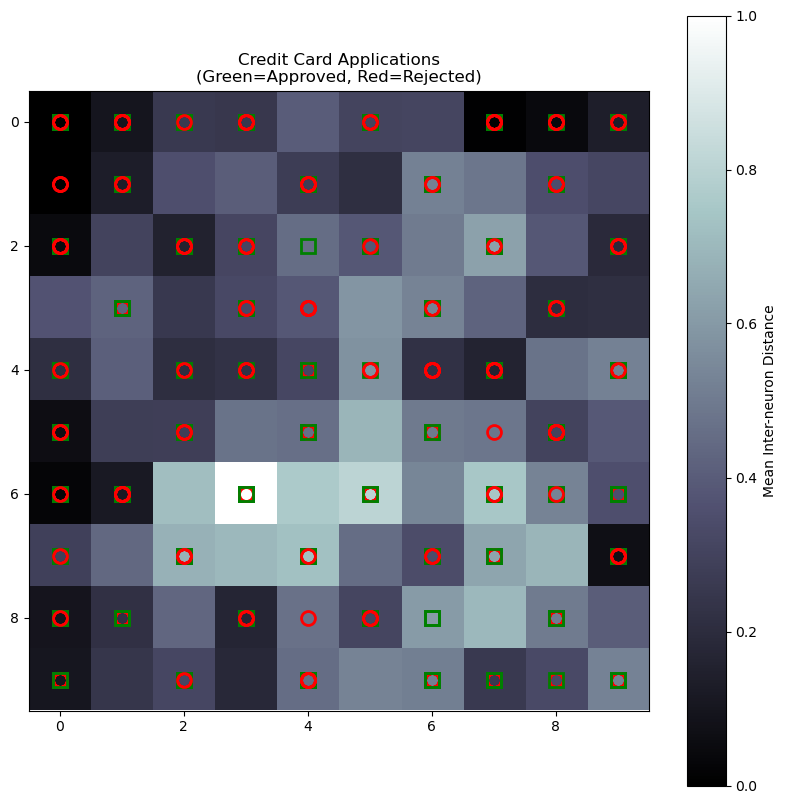

In [8]:
plt.figure(figsize=(10, 10))

# 1. Distance Map (Background)
plt.imshow(som.distance_map(), cmap='bone', interpolation='none')
plt.colorbar(label='Mean Inter-neuron Distance')

# 2. Plotting Markers
# We handle the mapping explicitly because LabelEncoder might assign 0/1 arbitrarily
try:
    pos_code = le.transform(['+'])[0]
except:
    pos_code = 0 # Fallback if '+' not found (unlikely)

for i, x in enumerate(X):
    w = som.find_winner(x)
    
    if y[i] == pos_code:
        # Approved -> Green Square
        m = 's'
        c = 'g'
    else:
        # Rejected -> Red Circle
        m = 'o'
        c = 'r'
    
    plt.plot(w[1], w[0],
             m,
             markeredgecolor=c,
             markerfacecolor='None',
             markersize=10,
             markeredgewidth=2)

plt.title('Credit Card Applications\n(Green=Approved, Red=Rejected)')
plt.show()